### Necessary Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("default")
plt.rcParams["figure.figsize"] = (6, 4)

### System Model

Parameters

In [2]:
# multi-cell NOMA
N = 3  # Number of users
N_index = np.arange(N)  # Index of users
M = 2  # Number of BSs
M_index = np.arange(M)  # Index of BSs
AREA = 500  # Area of the simulation m^2
ETA = 4  # path loss exponent
BANDWIDTH = 1e6  # bandwidth in Hz
NOISE = -170 + 10 * np.log10(BANDWIDTH)  # noise power in dBm
NOISE_LIN = 10 ** (NOISE / 10) / 1000  # noise power in linear scale
K = 5 * 10**4  # number of bits to be transmitted

# power parameters
Pt = np.linspace(-50, 20, 60)  # transmit power in dBm
Pt_lin = 10 ** (Pt / 10) / 1000  # transmit power in linear scale
P_circuit = 1e-3  # circuit power in Watts

Creating Layout

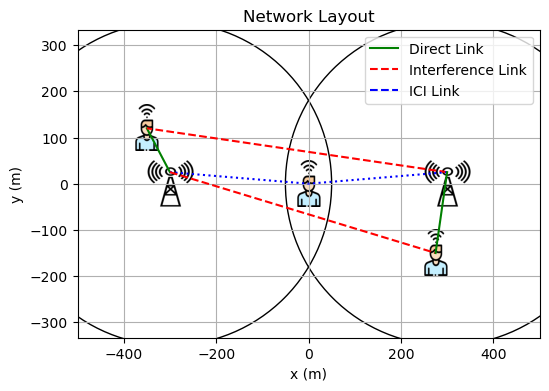

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.image import imread

# placing the base stations
bs_pos = np.array([[-300, 0], [300, 0]])
user_pos = np.array([[-350, 120], [0, 0], [275, -150]])

# plotting the layout
fig, ax = plt.subplots(figsize=(6, 4))
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.xlim([-AREA, AREA])
plt.ylim([-AREA / 1.5, AREA / 1.5])
plt.grid()

# add circle around base stations
for bs in bs_pos:
    circle = Circle(bs, radius=350, fill=False)
    ax.add_patch(circle)
    bs_img = imread("../resources/bs.png")
    plt.imshow(
        bs_img,
        extent=[bs[0] - 50, bs[0] + 50, bs[1] - 50, bs[1] + 50],
    )

for user in user_pos:
    for bs in bs_pos:
        if np.linalg.norm(user - bs) == np.min(np.linalg.norm(user_pos - bs, axis=1)):
            plt.plot([bs[0], user[0]], [bs[1] + 25, user[1]], "g-")
        else:
            if user.all() == user_pos[1].all():
                plt.plot([bs[0], user[0]], [bs[1] + 25, user[1]], "b:")
            else:
                plt.plot([bs[0], user[0]], [bs[1] + 25, user[1]], "r--")
    user_img = imread("../resources/user.png")
    plt.imshow(
        user_img,
        extent=[user[0] - 25, user[0] + 25, user[1] - 50, user[1] + 50],
    )
plt.plot([], [], "g-", label="Direct Link")
plt.plot([], [], "r--", label="Interference Link")
plt.plot([], [], "b--", label="ICI Link")

plt.title("Network Layout")
plt.legend()
plt.show()

### System Matrices

In [4]:
# find distances between users and base stations
distance_mat = np.sqrt(np.sum((user_pos[:, np.newaxis, :] - bs_pos) ** 2, axis=-1))

# generate channel coefficients
h = np.zeros((N, M, K // 2), dtype=np.complex128)

for i in range(M):
    for j in range(N):
        h[j, i, :] = (
            np.sqrt(distance_mat[j, i] ** (-ETA))
            * (np.random.randn(K // 2) + 1j * np.random.randn(K // 2))
            / np.sqrt(2)
        )

# find the channel gains
g = np.abs(h) ** 2

print("Gain Matrix:")
print(g.mean(axis=2))

Gain Matrix:
[[3.52615100e-09 5.27240596e-12]
 [1.23832022e-10 1.25578481e-10]
 [8.08232989e-12 1.85994599e-09]]


In [5]:
# generating noise
noise_mat = np.sqrt(NOISE_LIN / 2) * (
    np.random.randn(N, M, K // 2) + 1j * np.random.randn(N, M, K // 2)
)

print("Noise:")
print(noise_mat)

Noise:
[[[ 9.97698868e-08-8.62040987e-08j  9.17299219e-08+6.86007246e-08j
   -1.70455809e-07-1.10159109e-07j ... -2.62951533e-08+7.30070914e-08j
   -2.84530108e-08-9.76661594e-09j  1.09218435e-07-1.29882981e-07j]
  [ 1.06279470e-07-1.95902839e-08j  2.41835062e-08-4.89660309e-08j
   -2.78277660e-08+9.19752549e-09j ...  9.47812874e-08-3.36259276e-08j
    4.62748759e-08-1.43772849e-08j -5.61047357e-08-2.40221121e-08j]]

 [[-9.11441543e-08+6.03801986e-08j  5.78961214e-08-2.83064757e-08j
    1.73762767e-08+7.43165665e-08j ... -1.26675610e-07+3.73731048e-08j
    5.65639063e-08+4.73497533e-08j -2.27884213e-08+1.59778581e-08j]
  [ 6.48820968e-08-6.34196009e-08j  1.51386347e-08-3.86721973e-08j
   -1.08091278e-07+6.49246434e-08j ...  8.29018681e-09+6.71420020e-08j
   -1.62874730e-07+1.45644752e-08j -1.80791452e-08-5.47652552e-08j]]

 [[ 1.08080392e-07+5.98782963e-08j  7.49069756e-09+4.63343099e-08j
    1.59491929e-08+1.19844842e-07j ... -5.79517641e-08+9.33599652e-08j
   -1.24281983e-07+6.045870

### Power Allocation Factor

In [6]:
# assigning alpha factors for fixed allocation
alpha = np.zeros((N - 1, M))
alpha[:, 0] = (0.3, 0.7)
alpha[:, 1] = (0.7, 0.3)

print("Fixed Allocation Alpha:")
print(alpha)

Fixed Allocation Alpha:
[[0.3 0.7]
 [0.7 0.3]]


### Analysis

In [7]:
rate = np.zeros((N, K // 2))
user_rate = np.zeros((N, len(Pt_lin)))
sum_rate = np.zeros(len(Pt_lin))
outage = np.zeros((N, len(Pt_lin)))
r_min = 1.5
energy_eff = np.zeros(len(Pt_lin))
spectral_eff = np.zeros(len(Pt_lin))

for i in range(len(Pt_lin)):
    # rate for user 1
    rate[0, :] = np.log2(
        1
        + Pt_lin[i]
        * alpha[0, 0]
        * g[0, 0, :]
        / (NOISE_LIN + Pt_lin[i] * alpha[0, 0] * g[0, 1, :])
    )

    # rate for user 2
    rate[1, :] = np.log2(
        1
        + Pt_lin[i]
        * (alpha[0, 1] * g[1, 0, :] + alpha[1, 0] * g[1, 1, :])
        / (
            Pt_lin[i] * alpha[0, 0] * g[1, 0, :]
            + Pt_lin[i] * alpha[1, 1] * g[1, 1, :]
            + NOISE_LIN
        )
    )

    # rate for user 3
    rate[2, :] = np.log2(
        1
        + Pt_lin[i]
        * alpha[1, 1]
        * g[2, 1, :]
        / (NOISE_LIN + Pt_lin[i] * alpha[1, 1] * g[2, 0, :])
    )

    # sum rate
    user_rate[0, i] = np.mean(rate[0, :])
    user_rate[1, i] = np.mean(rate[1, :])
    user_rate[2, i] = np.mean(rate[2, :])
    sum_rate[i] = np.sum(np.mean(rate, axis=1))

    # outage probability
    for k in range(K // 2):
        if rate[0, k] < r_min:
            outage[0, i] += 1
        if rate[1, k] < r_min:
            outage[1, i] += 1
        if rate[2, k] < r_min:
            outage[2, i] += 1

    # SE-EE tradeoff
    spectral_eff[i] = sum_rate[i]  # already normalized by bandwidth
    energy_eff[i] = sum_rate[i] / (Pt_lin[i] + P_circuit)

outage /= K // 2

### Plots

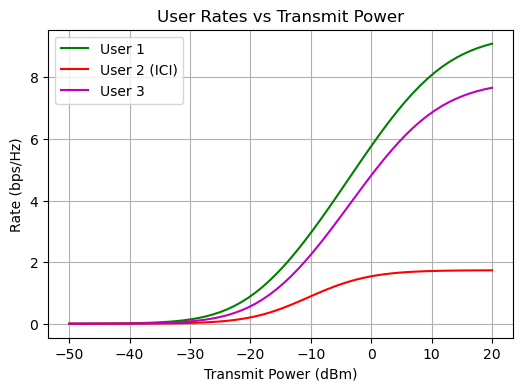

In [8]:
# user rates vs transmit power
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(Pt, user_rate[0, :], "g-", label="User 1")
plt.plot(Pt, user_rate[1, :], "r-", label="User 2 (ICI)")
plt.plot(Pt, user_rate[2, :], "m-", label="User 3")
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Rate (bps/Hz)")
plt.title("User Rates vs Transmit Power")
plt.legend()
plt.grid()
plt.show()

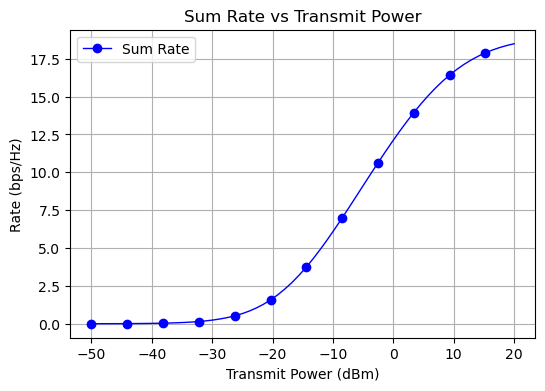

In [9]:
# sum rate vs transmit power
fig = plt.figure(figsize=(6, 4))
plt.plot(Pt, sum_rate, "b-", label="Sum Rate", linewidth=1, marker="o", markevery=5)
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Rate (bps/Hz)")
plt.title("Sum Rate vs Transmit Power")
plt.legend()
plt.grid()
plt.show()

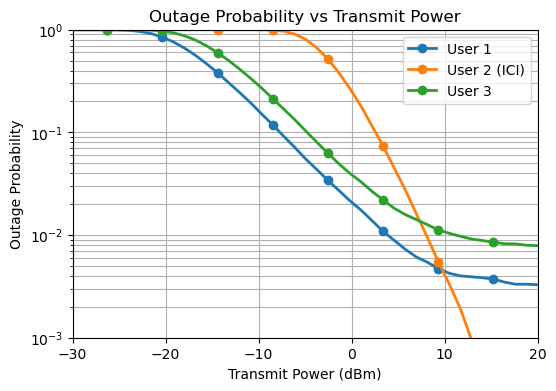

In [10]:
# outage probability vs transmit power
fig, ax = plt.subplots(figsize=(6, 4))
plt.semilogy(Pt, outage[0, :], label="User 1", marker="o", linewidth=2, markevery=5)
plt.semilogy(
    Pt, outage[1, :], label="User 2 (ICI)", marker="o", linewidth=2, markevery=5
)
plt.semilogy(Pt, outage[2, :], label="User 3", marker="o", linewidth=2, markevery=5)
plt.xlabel("Transmit Power (dBm)")
plt.ylabel("Outage Probability")
plt.title("Outage Probability vs Transmit Power")
plt.xlim([-30, 20])
plt.ylim([1e-3, 1])
plt.legend()
plt.grid(which="both")
plt.show()

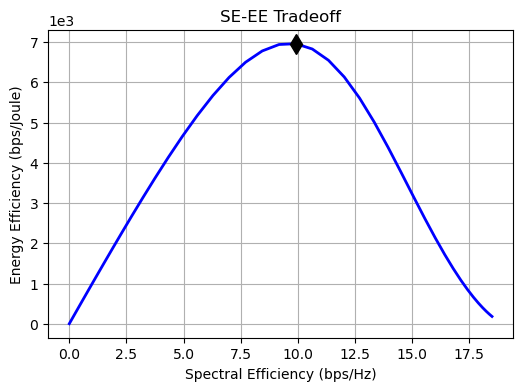

In [11]:
# SE-EE tradeoff
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(spectral_eff, energy_eff, "b-", linewidth=2)
plt.xlabel("Spectral Efficiency (bps/Hz)")
plt.ylabel("Energy Efficiency (bps/Joule)")
plt.title("SE-EE Tradeoff")
plt.grid()

# Find the peak point
peak_idx = np.argmax(energy_eff)
peak_x = spectral_eff[peak_idx]
peak_y = energy_eff[peak_idx]

# Add a marker at the peak point
plt.plot(peak_x, peak_y, marker="d", markersize=10, color="black")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.show()